# Statistiques descriptives base de données

In [23]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.stats import gaussian_kde
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
import os
from matplotlib import rcParams

# Définir Times New Roman comme police par défaut pour tout le graphique
rcParams['font.family'] = 'Times New Roman'

df = pd.read_csv("finalbase.csv", sep=',')
print(df.columns)
print(df.shape)
panel = pd.read_csv("panel_finalbase.csv", sep=',')

Index(['Unnamed: 0.1', 'Unnamed: 0', 'siren', 'brevets2016', 'brevets2017',
       'brevets2018', 'brevets2019', 'brevets2020', 'CIR2016', 'CIR2017',
       'CIR2018', 'CIR2019', 'CIR2020', 'Id_ETI', 'dateCreationUniteLegale',
       'division'],
      dtype='object')
(2593, 16)


# Nombres d'entrerpises (totale, CIR et brevets) en fonction des secteurs et des catégories juridiques
Je recherche dans cette partie à regarder dans quels secteurs sont mes entreprises et si elles sont des ETI ou des GE

In [24]:
""" Création d'un dictionnaire de traduction des divisions NAF vers secteur"""

dic = pd.read_csv('naf2008_liste_n2.csv', sep=';')
dic.columns = ['NAF','secteur']
print(dic.columns)
dictionnaire_division = dict(zip(dic['NAF'], dic['secteur']))

Index(['NAF', 'secteur'], dtype='object')


In [25]:
""" Nombre d'entreprise(total, ETI, GE) et autres """
count_eti_ge = df['Id_ETI'].value_counts()


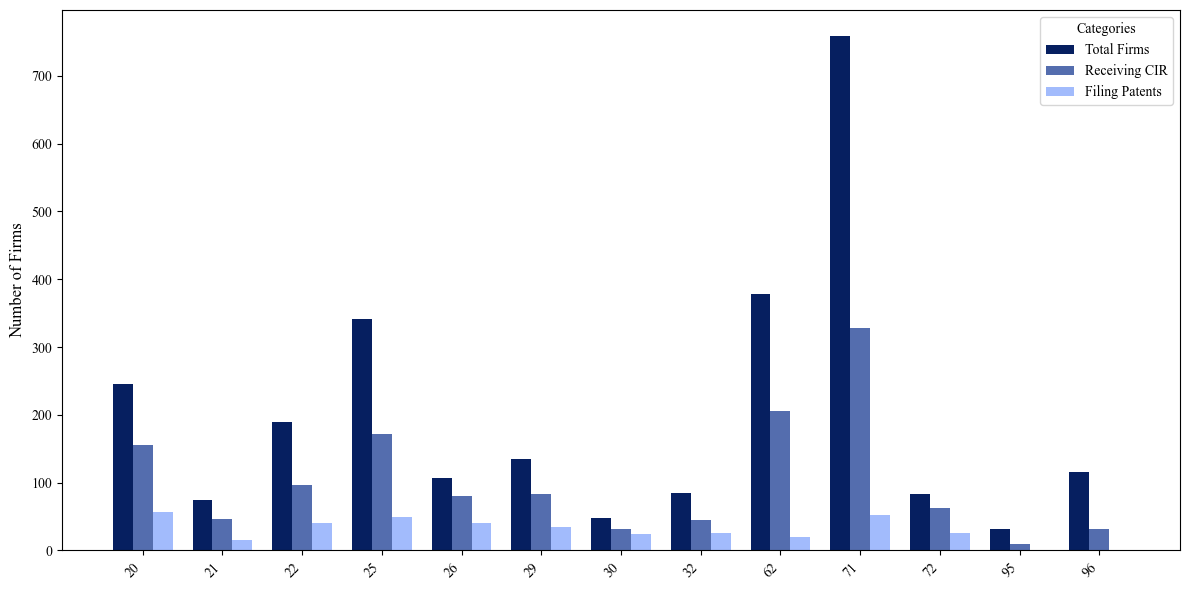

In [26]:
# Assurez-vous que les colonnes nécessaires sont converties au format numérique
df[['CIR2016', 'CIR2017', 'CIR2018', 'CIR2019', 'CIR2020']] = df[['CIR2016', 'CIR2017', 'CIR2018', 'CIR2019', 'CIR2020']].apply(pd.to_numeric, errors='coerce')
df[['brevets2016', 'brevets2017', 'brevets2018', 'brevets2019', 'brevets2020']] = df[['brevets2016', 'brevets2017', 'brevets2018', 'brevets2019', 'brevets2020']].apply(pd.to_numeric, errors='coerce')

# Assurez-vous que 'division' est une chaîne de caractères
df['division'] = df['division'].astype(str)

# Calcul du nombre total d'entreprises par division
df_total = df.groupby('division').size()

# Calcul du nombre d'entreprises recevant du CIR
df_cir = df[(df[['CIR2016', 'CIR2017', 'CIR2018', 'CIR2019', 'CIR2020']] > 0).any(axis=1)]
df_cir_count = df_cir.groupby('division').size()

# Calcul du nombre d'entreprises ayant déposé au moins un brevet
df_brevets = df[(df[['brevets2016', 'brevets2017', 'brevets2018', 'brevets2019', 'brevets2020']] > 0).any(axis=1)]
df_brevets_count = df_brevets.groupby('division').size()

# Combiner les données dans un seul DataFrame pour un affichage cohérent
df_combined = pd.DataFrame({
    'Total Firms': df_total,
    'Receiving CIR': df_cir_count,
    'Filing Patents': df_brevets_count
}).fillna(0)  # Remplacer les valeurs NaN par 0

# Préparer le graphique
bar_width = 0.25
indices = np.arange(len(df_combined))

# Créer la figure
fig, ax = plt.subplots(figsize=(12, 6))

# Tracer les barres pour chaque catégorie
ax.bar(indices - bar_width, df_combined['Total Firms'], bar_width, label='Total Firms', color='#061F60')
ax.bar(indices, df_combined['Receiving CIR'], bar_width, label='Receiving CIR', color='#546DAE')
ax.bar(indices + bar_width, df_combined['Filing Patents'], bar_width, label='Filing Patents', color='#A2BBFC')

# Ajouter des labels et un titre
ax.set_xlabel('', fontsize=12)
ax.set_ylabel('Number of Firms', fontsize=12)
ax.set_title('', fontsize=16)
ax.set_xticks(indices)
ax.set_xticklabels(df_combined.index, rotation=45, ha='right')

# Ajouter une légende
ax.legend(title='Categories', fontsize=10)

# Afficher le graphique
plt.tight_layout()
plt.show()


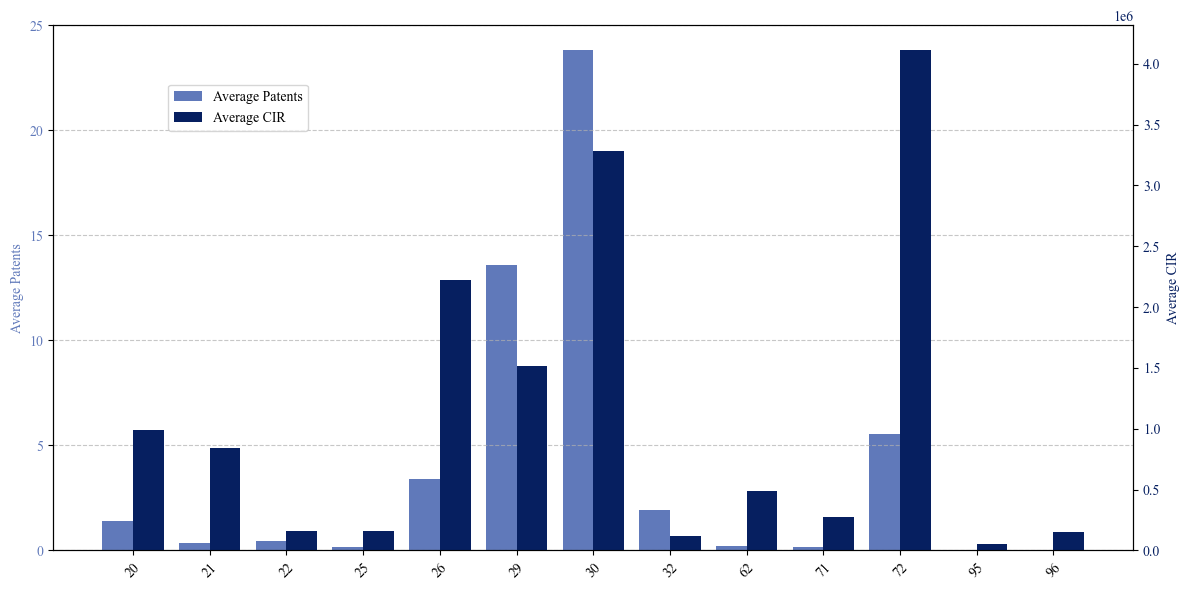

In [28]:
"""Average CIR and patents production per division"""

# Calculer les moyennes par division
mean_brevets_by_sector = panel.groupby('division')['brevets'].mean()
mean_CIR_by_sector = panel.groupby('division')['CIR'].mean()
plt.rc('font', family='Times New Roman')
# Préparer les données
sectors = mean_brevets_by_sector.index
x = np.arange(len(sectors))  # Positions des secteurs

# Créer le graphique
fig, ax1 = plt.subplots(figsize=(12, 6))

# Largeur des barres
bar_width = 0.4

# Axe de gauche : Nombre moyen de brevets
color1 =c='#6079BA'
ax1.bar(x - bar_width / 2, mean_brevets_by_sector.values, width=bar_width, color=color1, label='Average Patents')
ax1.set_xlabel('')
ax1.set_ylabel('Average Patents', color=color1)
ax1.tick_params(axis='y', labelcolor=color1)
ax1.set_xticks(x)
ax1.set_xticklabels(sectors, rotation=45)

# Axe de droite : CIR moyen
ax2 = ax1.twinx()  # Crée un second axe partageant le même axe x
color2 = '#061F60'
ax2.bar(x + bar_width / 2, mean_CIR_by_sector.values, width=bar_width, color=color2, label='Average CIR')
ax2.set_ylabel('Average CIR', color=color2)
ax2.tick_params(axis='y', labelcolor=color2)

# Ajouter une grille pour l'axe de gauche
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# Ajouter une légende
fig.legend(loc="upper left", bbox_to_anchor=(0.1, 0.9), bbox_transform=ax1.transAxes)

# Afficher le graphique
plt.tight_layout()
plt.show()

# Etude brevet et CIR pour les entreprises du dataframe
Je représente dans cette partie pour chaque année :
- nombre d'ETI ayant reçu du CIR
- nombre de GE ayant reçu du CIR
- nombre d'entreprise ayant déposé un brevet
- moyenne du nombre de brevet ayant déposé plus que zéro brevet

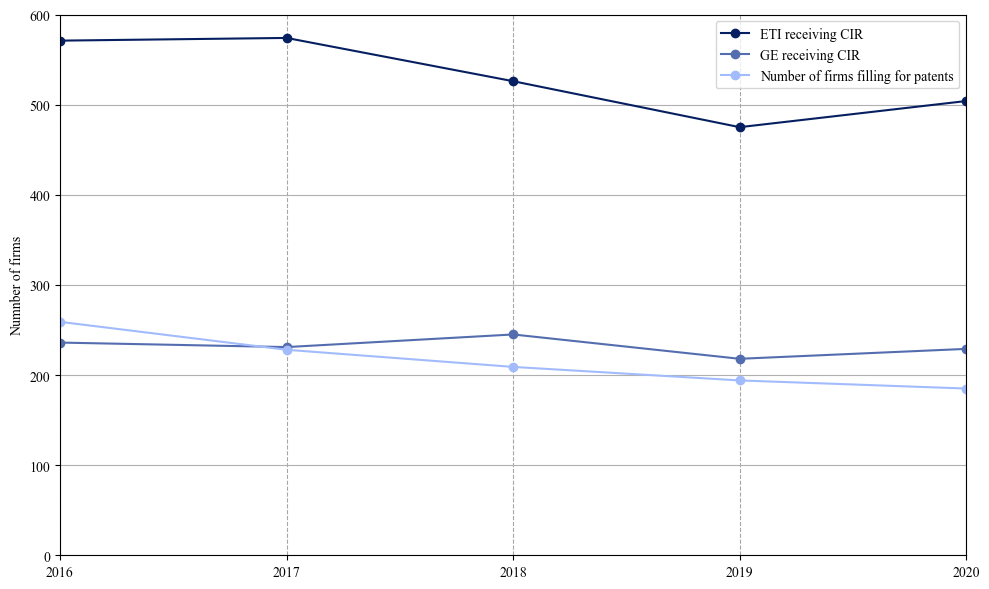

In [19]:
# Liste des années à traiter
annees = [2016, 2017, 2018, 2019, 2020]

# Initialisation des listes pour stocker les données
eti_cir = []
ge_cir = []
brevets = []
moyenne_brevets = []

# Boucle sur chaque année pour collecter les données
for annee in annees:
    # Filtrer les entreprises ayant reçu un CIR > 0
    cir_col = f'CIR{annee}'
    brevets_col = f'brevets{annee}'
    
    df_cir = df[df[cir_col] > 0]
    df_brevets = df[df[brevets_col] > 0]
    
    # Séparer les entreprises par catégorie
    df_cir_eti = df_cir[df_cir['Id_ETI'] == 1]
    df_cir_ge = df_cir[df_cir['Id_ETI'] == 0]
    
    # Calcul des valeurs pour chaque année
    nombre_cir_eti = df_cir_eti.shape[0]  # Nombre d'ETI ayant reçu du CIR
    nombre_cir_ge = df_cir_ge.shape[0]    # Nombre de GE ayant reçu du CIR
    nombre_brevets = df_brevets.shape[0]  # Nombre d'entreprises ayant déposé un brevet
    moyenne_brevets_val = df_brevets[brevets_col].mean() if not df_brevets.empty else 0  # Moyenne des brevets
    
    # Ajouter les données aux listes
    eti_cir.append(nombre_cir_eti)
    ge_cir.append(nombre_cir_ge)
    brevets.append(nombre_brevets)
    moyenne_brevets.append(moyenne_brevets_val)

# Créer le graphique
plt.figure(figsize=(10, 6))

# Tracer les courbes
plt.plot(annees, eti_cir, label="ETI receiving CIR", color='#061F60', marker='o')
plt.plot(annees, ge_cir, label="GE receiving CIR", color='#546DAE', marker='o')
plt.plot(annees, brevets, label="Number of firms filling for patents", color='#A2BBFC', marker='o')
#plt.plot(annees, moyenne_brevets, label="Moyenne des brevets déposés", color='red', marker='o')
plt.ylim(0,600)
# Ajouter des légendes, titre et labels
plt.title("")
plt.xlabel("")
plt.ylabel("Numnber of firms")
plt.legend()
plt.grid(True)
plt.xticks(ticks=annees, labels=annees, fontsize=10)  # S'assurer que les ticks sont entiers et alignés sur les années
plt.xlim(min(annees), max(annees))  # Limiter l'axe x aux années disponibles

# Ajouter des grilles uniquement aux entiers (alignées sur les ticks)
plt.grid(True, which='major', axis='x', linestyle='--', color='gray', alpha=0.7) 

# Ajuster l'affichage
plt.tight_layout()

plt.savefig("Evolution of the number of firms receiving CIR and filling patents.png")
plt.show()



# Variance et Etalement des données
On regarde boite à moustache des valeurs de CIR et de brevets sur toutes les années sans distincition de catégories et de secteurs pour les entreprises. 

C:\Users\lucie\AppData\Local\Temp\ipykernel_13688\655135307.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(annees)
C:\Users\lucie\AppData\Local\Temp\ipykernel_13688\655135307.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(annees)


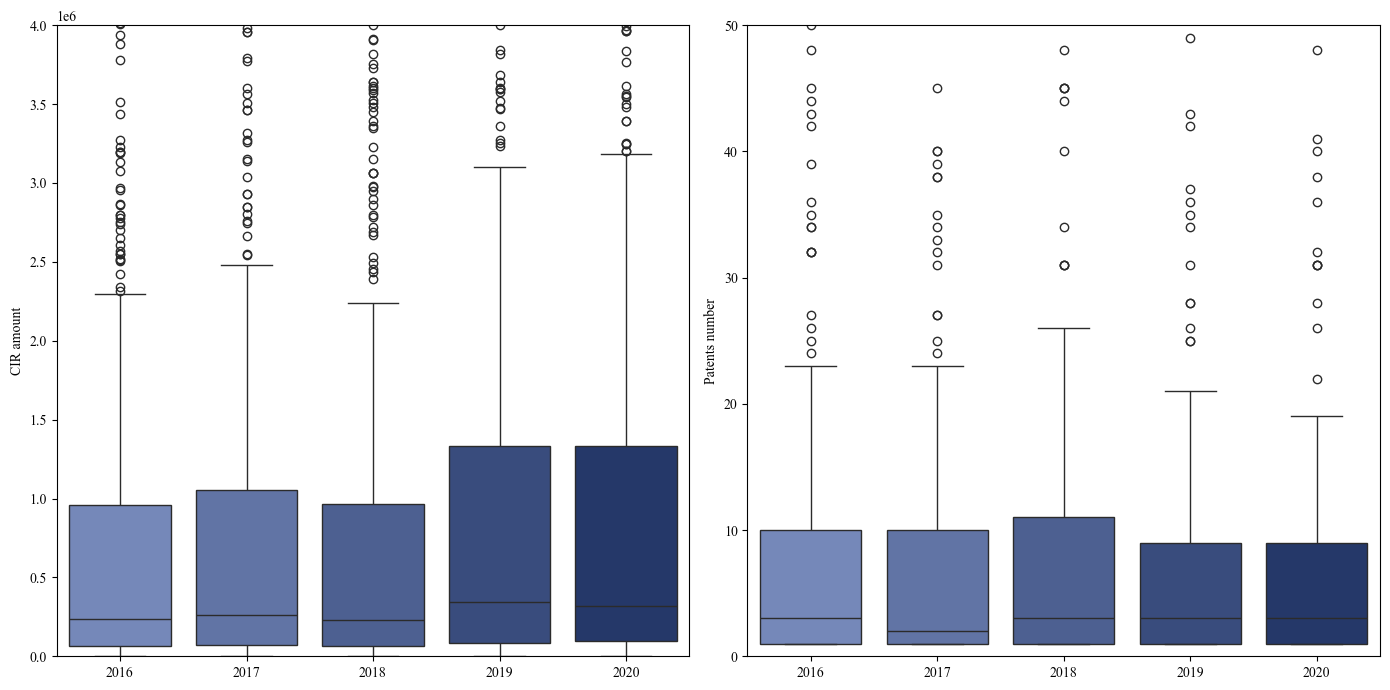

In [ ]:
# Préparer les données pour les boxplots
# Créer des listes vides pour chaque année
# Configuration de la police : Times New Roman
plt.rcParams["font.family"] = "Times New Roman"
montants_cir = []
annees =range(2016,2021)
nombres_brevets = []
camaieu_rgb=[(86,111,176),(66,91,156),(46,71,136),(26,51,116),(6,31,96)]
camaieu_rgb_plus_20 = [
    (min(r + 20, 255), min(g + 20, 255), min(b + 20, 255)) for r, g, b in camaieu_rgb
]
# Normalisation des couleurs en divisant par 255
camaieu = [(r/255, g/255, b/255) for r, g, b in camaieu_rgb_plus_20]
for annee in annees:
    # Créer les colonnes de CIR et de brevets pour chaque année
    cir_col = f'CIR{annee}'
    brevets_col = f'brevets{annee}'

    # Ajouter les montants CIR (en excluant ceux égaux à 0) et les nombres de brevets (en excluant ceux égaux à 0) pour chaque année
    montants_cir.append(df[df[cir_col] > 100][cir_col].dropna())  # Exclure CIR = 0 et supprimer les NaN
    nombres_brevets.append(df[df[brevets_col] > 0][brevets_col].dropna())  # Exclure Brevets = 0 et supprimer les NaN

# Initialisation de la figure
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

# Graphique 1 : Boxplot des montants de CIR (en excluant les CIR = 0)
sns.boxplot(data=montants_cir, ax=axes[0], palette=camaieu)
axes[0].set_xticklabels(annees)
axes[0].set_ylabel('CIR amount')
axes[0].set_ylim(0, 4000000)

# Graphique 2 : Boxplot des nombres de brevets (en excluant les Brevets = 0)
sns.boxplot(data=nombres_brevets, ax=axes[1], palette=camaieu)
axes[1].set_xticklabels(annees)
axes[1].set_ylabel('Patents number')
axes[1].set_ylim(0, 50)

# Ajuster l'affichage des graphiques
plt.tight_layout()
plt.savefig("Distribution per year.png")

plt.show()

Maintenant je regarde les étalement des valeurs de CIR reçu en fonction de la catégorie des entreprises sans distinction d'années.

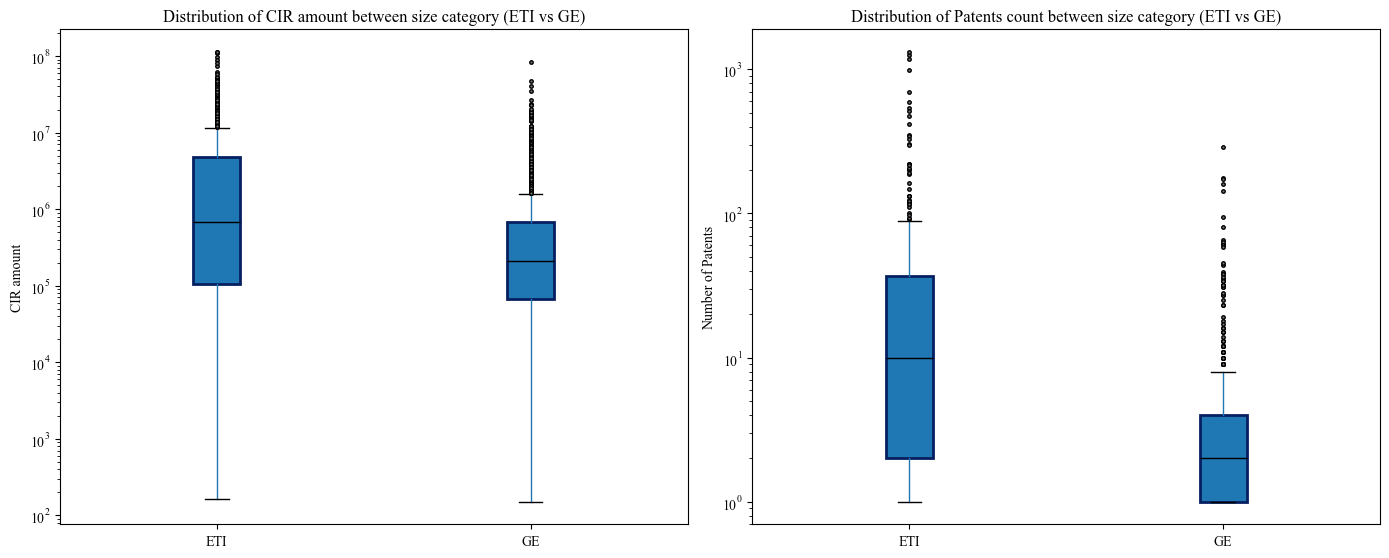

In [ ]:
# Sélectionner les colonnes 'CIR' et 'brevets'
cols_cir = [col for col in df.columns if 'CIR' in col]
cols_brevets = [col for col in df.columns if 'brevets' in col]

# Melt les colonnes 'CIR' et 'brevets'
df_cir = df[cols_cir + ['Id_ETI']].melt(id_vars=['Id_ETI'], var_name='Année', value_name='Montant')
df_cir['Type'] = 'CIR'  # Ajouter une colonne 'Type' pour identifier les CIR

df_brevets = df[cols_brevets + ['Id_ETI']].melt(id_vars=['Id_ETI'], var_name='Année', value_name='Montant')
df_brevets['Type'] = 'brevets'  # Ajouter une colonne 'Type' pour identifier les brevets

# Fusionner les deux DataFrames
df_long = pd.concat([df_cir, df_brevets], ignore_index=True)

df_long['Type'] = df_long['Année'].apply(lambda x: 'CIR' if 'CIR' in x else 'brevets')

# Filtrage pour les montants de CIR et de brevets
df_long_cir = df_long[(df_long['Type'] == 'CIR') & (df_long['Montant'] > 100)]
df_long_brevets = df_long[(df_long['Type'] == 'brevets') & (df_long['Montant'] > 0)]

# Vérifier si les données de CIR et de brevets sont disponibles après filtrage
if not df_long_cir.empty and not df_long_brevets.empty:
    # Créer un graphique avec 2 subplots
    boxprops_cir = dict(color="#061F60",linewidth=2)  # Définir la couleur et l'épaisseur des bordures
    flierprops_cir = dict(marker='.', markerfacecolor='#767676', markersize=5)  # Personnal
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Boxplot pour les montants de CIR
    df_long_cir.boxplot(column='Montant', by='Id_ETI', grid=False, ax=axes[0], boxprops=boxprops_cir, flierprops=flierprops_cir, patch_artist=True, 
                       medianprops=dict(color='black'))
    axes[0].set_title("Distribution of CIR amount between size category (ETI vs GE)")
    axes[0].set_xlabel("")
    axes[0].set_ylabel("CIR amount")
    axes[0].set_yscale('log')  # Échelle logarithmique pour le CIR
    axes[0].set_xticklabels(['ETI' if label == 1 else 'GE' for label in axes[0].get_xticks()])
    # Boxplot pour le nombre de brevets
    df_long_brevets.boxplot(column='Montant', by='Id_ETI', grid=False, ax=axes[1], boxprops=boxprops_cir, flierprops=flierprops_cir, patch_artist=True, 
                       medianprops=dict(color='black'))
    axes[1].set_title("Distribution of Patents count between size category (ETI vs GE)")
    axes[1].set_xlabel("")
    axes[1].set_ylabel("Number of Patents")
    axes[1].set_yscale('log')  # Échelle logarithmique pour les brevets
    axes[1].set_xticklabels(['ETI' if label == 1 else 'GE' for label in axes[0].get_xticks()])
    # Ajuster l'affichage
    plt.tight_layout()
    plt.suptitle("")  # Supprimer le titre par défaut
    plt.savefig("Distribution per size.png")
    plt.show()
else:
    print("Aucune donnée de CIR ou de brevets disponible après filtrage.")

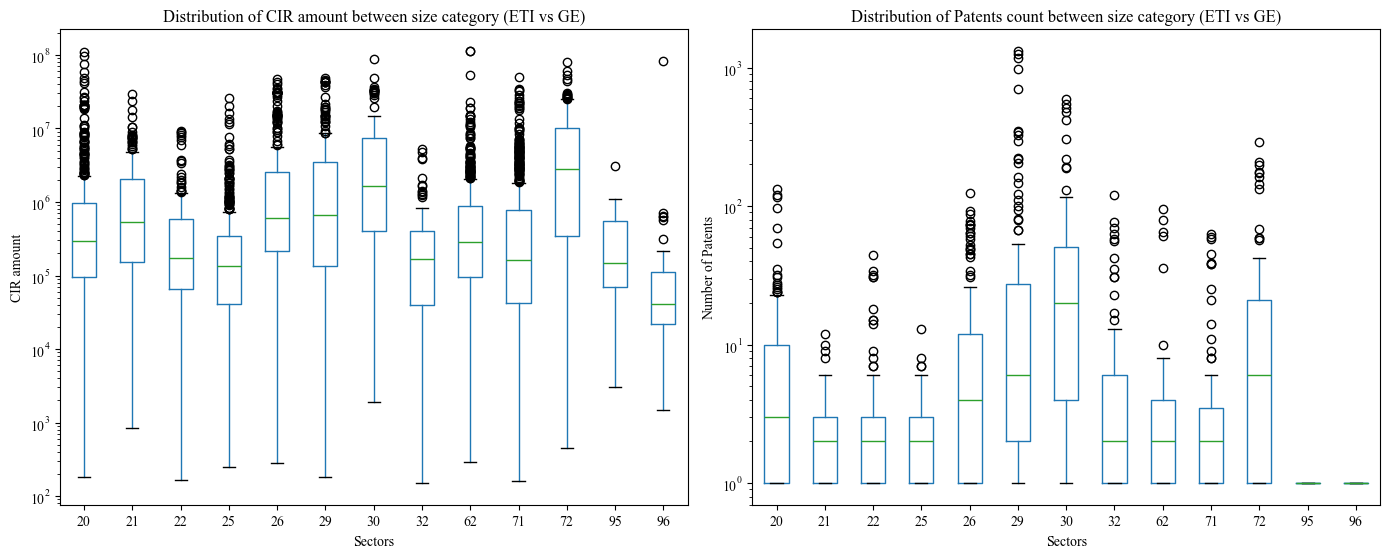

In [20]:
#Sélectionner les colonnes 'CIR' et 'brevets'
cols_cir = [col for col in df.columns if 'CIR' in col]
cols_brevets = [col for col in df.columns if 'brevets' in col]

# Melt les colonnes 'CIR' et 'brevets'
df_cir = df[cols_cir + ['division']].melt(id_vars=['division'], var_name='Année', value_name='Montant')
df_cir['Type'] = 'CIR'  # Ajouter une colonne 'Type' pour identifier les CIR

df_brevets = df[cols_brevets + ['division']].melt(id_vars=['division'], var_name='Année', value_name='Montant')
df_brevets['Type'] = 'brevets'  # Ajouter une colonne 'Type' pour identifier les brevets

# Fusionner les deux DataFrames
df_long = pd.concat([df_cir, df_brevets], ignore_index=True)

df_long['Type'] = df_long['Année'].apply(lambda x: 'CIR' if 'CIR' in x else 'brevets')

# Filtrage pour les montants de CIR et de brevets
df_long_cir = df_long[(df_long['Type'] == 'CIR') & (df_long['Montant'] > 100)]
df_long_brevets = df_long[(df_long['Type'] == 'brevets') & (df_long['Montant'] > 0)]

# Vérifier si les données de CIR et de brevets sont disponibles après filtrage
if not df_long_cir.empty and not df_long_brevets.empty:
    # Créer un graphique avec 2 subplots
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Boxplot pour les montants de CIR
    df_long_cir.boxplot(column='Montant', by='division', grid=False, ax=axes[0])
    axes[0].set_title("Distribution of CIR amount between size category (ETI vs GE)")
    axes[0].set_xlabel("Sectors")
    axes[0].set_ylabel("CIR amount")
    axes[0].set_yscale('log')  # Échelle logarithmique pour le CIR
    
    # Boxplot pour le nombre de brevets
    df_long_brevets.boxplot(column='Montant', by='division', grid=False, ax=axes[1])
    axes[1].set_title("Distribution of Patents count between size category (ETI vs GE)")
    axes[1].set_xlabel("Sectors")
    axes[1].set_ylabel("Number of Patents")
    axes[1].set_yscale('log')  # Échelle logarithmique pour les brevets
    
    # Ajuster l'affichage
    plt.tight_layout()
    plt.suptitle("")  # Supprimer le titre par défaut
    plt.savefig("Distribution per division.png")
    plt.show()
else:
    print("Aucune donnée de CIR ou de brevets disponible après filtrage.")

Distribution relativement similaires entre ETI et GE, un peu moins de CIR reçu pour le 3e quartiles des ETI et à la place beaucoup de outliers.

# Première visualisation de corrélation

C:\Users\lucie\AppData\Local\Temp\ipykernel_23464\1481798490.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['CIR_total'] = df_filtered[cir_columns].sum(axis=1)
C:\Users\lucie\AppData\Local\Temp\ipykernel_23464\1481798490.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['brevets_total'] = df_filtered[brevets_columns].sum(axis=1)


en épurant les données, nous obtenons 1346 entreprises


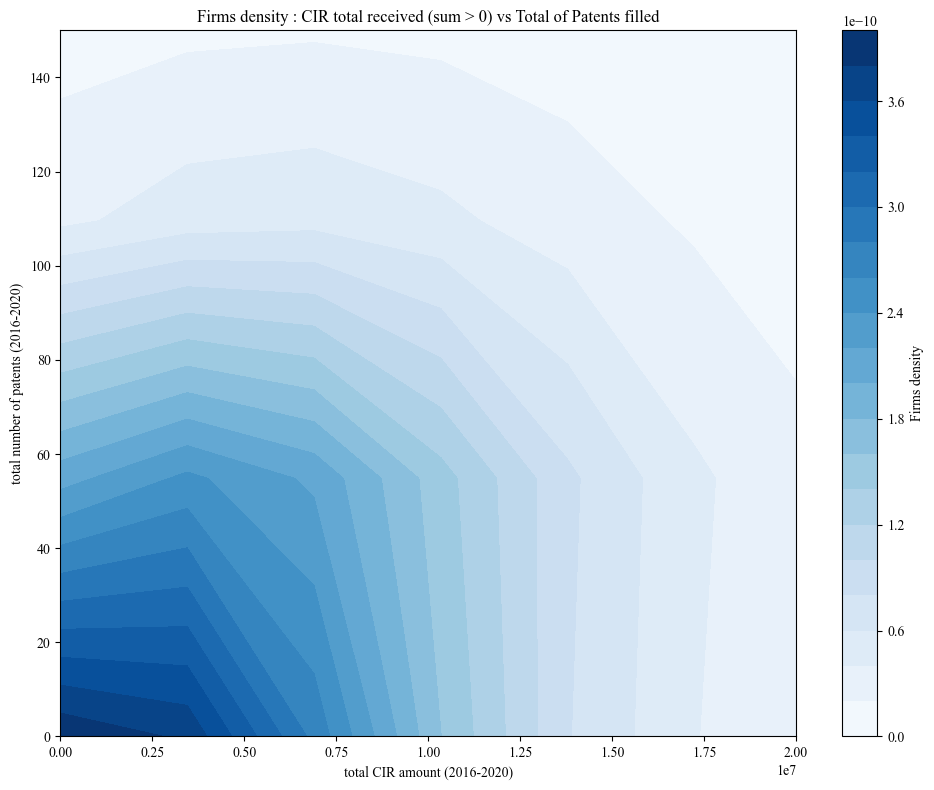

In [21]:

# Filtrer les entreprises qui ont un CIR entre 0 et 1000 dans n'importe quelle année
cir_columns = ['CIR2016', 'CIR2017', 'CIR2018', 'CIR2019', 'CIR2020']
df_filtered = df[df[cir_columns].sum(axis=1) != 0]

# Calculer le CIR total sur la période 2016-2023 pour les entreprises restantes
df_filtered['CIR_total'] = df_filtered[cir_columns].sum(axis=1)

# Calculer le nombre total de brevets sur la période 2016-2023 pour les entreprises restantes
brevets_columns = ['brevets2016', 'brevets2017', 'brevets2018', 'brevets2019', 'brevets2020']
df_filtered['brevets_total'] = df_filtered[brevets_columns].sum(axis=1)

# Filtrer les entreprises avec un CIR total > 1000 et des brevets > 0
#df_filtered = df_filtered[(df_filtered['brevets_total'] <1000)]
#df_filtered = df_filtered[(df_filtered['brevets_total'] > 0)]
print(f"en épurant les données, nous obtenons {df_filtered.shape[0]} entreprises")

# Créer les listes pour les axes
montants_cir = df_filtered['CIR_total'].values
nombres_brevets = df_filtered['brevets_total'].values

# Convertir en tableau numpy pour faciliter l'indexation
x = np.array(montants_cir)
y = np.array(nombres_brevets)

# Calculer la densité avec KDE (Kernel Density Estimation)
kde = gaussian_kde([x, y])

# Créer une grille de points pour calculer la densité
x_grid = np.linspace(min(x), max(x), 100)
y_grid = np.linspace(min(y), max(y), 100)
X, Y = np.meshgrid(x_grid, y_grid)
Z = kde([X.flatten(), Y.flatten()]).reshape(X.shape)

# Créer un graphique de contours
plt.figure(figsize=(10, 8))
cp = plt.contourf(X, Y, Z, levels=20, cmap='Blues')

# Ajouter des étiquettes pour les axes
plt.xlabel('total CIR amount (2016-2020)')
plt.ylabel('total number of patents (2016-2020)')

# Ajouter un titre
plt.title('Firms density : CIR total received (sum > 0) vs Total of Patents filled')
plt.ylim(0,150)
plt.xlim(0,0.2*1e8)
# Afficher la barre de couleur
plt.colorbar(cp, label='Firms density')
# Affichage
plt.tight_layout()
plt.savefig("Firms density.png")
plt.show()
 
